<a href="https://colab.research.google.com/github/horstl/ProtFlow/blob/master/examples/colab_tutorials/ProtFlow_tutorial_RiffDiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use ProtFlow in combination with RiffDiff to create an artifical motif library

This tutorial shows how how to employ [ProtFlow](https://github.com/mabr3112/ProtFlow) in combination with the rotamer inverted fragment finder [RiffDiff](https://github.com/mabr3112/riff_diff_protflow/) to create a starting point from a theozyme for an enzyme design project like that on [here](https://www.biorxiv.org/content/10.1101/2024.08.02.606416v2).
*Artificial motifs* are computed from a combination of idealized helices and an *catalytic array* of amino acid sidechains. The rotamers of each amino acid are selected to be compatible with the phi-psi angle combination of the fragment backbone. The combinations of helical fragments are fitleres regarding their compatibility (no steric clashes,...) and an artificial motifs, used as input for a backbone design methods are provided.
The script starts by inverting rotamers of the catalytic array, which fixes the functional groups in space and varies the position of their backbone atoms. Rotamers are selected for backbone compatibility with the helical fragments and subsequently placed onto the fragment’s backbone atoms. Next, a search for all possible combinations of fragments that are not sterically clashing with each other is performed. Non-clashing assemblies are ranked according to the rotamer probabilities of the individual active site residues and by their abundance in the protein data bank (PDB). The identified assemblies are aggregated and stored in an artificial motif library
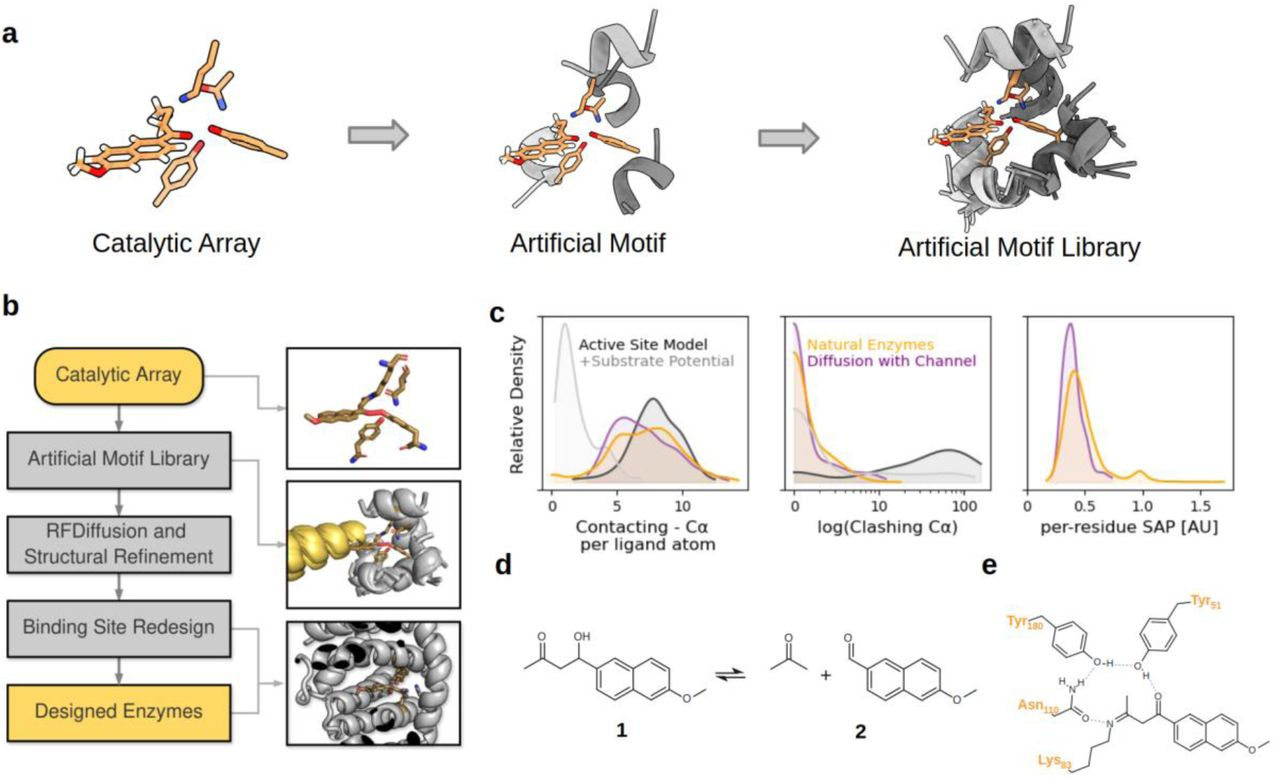



# ProtFlow/RiffDiff installation
Now we will install ProtFlow and RiffDiff. Additonally a [config file](https://github.com/mabr3112/ProtFlow?tab=readme-ov-file#the-configuration-file) for ProtFlow is set up.

In [ ]:
# ================================
# RiffDiff INSTALL
# ================================

!git clone https://github.com/mabr3112/riff_diff_protflow.git
print("✓ RiffDiff complete")


# ================================
# PROTFLOW SETUP
# ================================

import sys
!{sys.executable} -m pip install git+https://github.com/mabr3112/ProtFlow.git
!protflow-init-config
!ln -s /usr/bin/python3.12 /usr/bin/python
print("✓ ProtFlow setup complete")


# ================================
# VIEWER SETUP
# ================================

!pip install py3Dmol



In [ ]:
%%writefile /root/.config/protflow/config.py
'''
This module contains all paths to tools integrated in ProtFlow. PRE_CMD are commands that should be run before the runner is executed (e.g. if import of a specific module is necessary for the environment to work)
'''
# path to root directory of ProtFlow:
PROTFLOW_DIR = "/content/ProtFlow/"

# protflow environment python
PROTFLOW_ENV = "/usr/bin/"

# auxiliary runners directory path
AUXILIARY_RUNNER_SCRIPTS_DIR = "/content/ProtFlow/protflow/tools/runners_auxiliary_scripts/"

# protein_generator.py
PROTEIN_GENERATOR_SCRIPT_PATH = "/content/ProtFlow/protflow/tools/runners_auxiliary_scripts/protein_generator.py"
PROTEIN_GENERATOR_PYTHON_PATH = "/usr/bin/python"

# ligandmpnn.py
LIGANDMPNN_SCRIPT_PATH =  ""#"/content/LigandMPNN/run.py"
LIGANDMPNN_PYTHON_PATH = "" #"/root/micromamba/envs/ligandmpnn/bin/python"
LIGANDMPNN_PRE_CMD = "" # "echo 'this will be printed before running ligandmpnn'"

# rosetta.py
ROSETTA_BIN_PATH = "" # "/path/to/Rosetta/main/source/bin/"
ROSETTA_PRE_CMD = ""

# attnpacker.py
ATTNPACKER_PYTHON_PATH = "" # "/path/to/anaconda3/envs/attnpacker/bin/python3"
ATTNPACKER_DIR_PATH = "" # "/path/to/AttnPacker/"
ATTNPACKER_PRE_CMD = ""

# rfdiffusion.py
RFDIFFUSION_SCRIPT_PATH = "" #"/content/RFdiffusion/scripts/run_inference.py"
RFDIFFUSION_PYTHON_PATH = "" #"/root/micromamba/envs/SE3nv/bin/python"
RFDIFFUSION_PRE_CMD = ""

# esmfold.py
ESMFOLD_PYTHON_PATH = "" # "/path/to/miniconda3/envs/esm/bin/python"
ESMFOLD_PRE_CMD = ""

# af2
COLABFOLD_SCRIPT_PATH = "" # "/path/to/localcolabfold/colabfold-conda/bin/colabfold_batch"
COLABFOLD_PRE_CMD = ""

# fpocket
FPOCKET_PATH = "" # "/path/to/anaconda3/envs/protslurm/bin/fpocket"

# dssp
DSSP_PATH = "" #"/usr/bin/dssp"

# boltz
BOLTZ_PATH = "" #"/root/micromamba/envs/boltz/bin/boltz"
BOLTZ_PYTHON_PATH = ""#"/root/micromamba/envs/boltz/bin/python3"
BOLTZ_PRE_CMD = ""

# gromacs
GROMACS_PATH = "" #/path/to/gromacs/bin/

# PLACER
PLACER_SCRIPT_PATH = "" # "/path/to/PLACER/run_PLACER.py"
PLACER_PYTHON_PATH = "" # "/path/to/mambaforge/envs/placer/bin/python"
PLACER_PRE_CMD = ""

# ESM
ESM_PYTHON_PATH = "" # "/path/to/package_manager/envs/your_esm_env/bin/python"
ESM_PRE_CMD = ""

# protein generator
PROTEIN_GENERATOR_PYTHON_PATH = "/usr/bin/python"
PROTEIN_GENERATOR_SCRIPT_PATH = "/content/ProtFlow/protflow/tools/runners_auxiliary_scripts/protein_generator.py"

# 1.Starting point
For this workflow a catalytic array with a substrate/product/inhibitor is needed. We use as starting point the retro-aldolase [RA95.5-8F](https://www.rcsb.org/structure/5AN7) with its bound inhibitor.
In the next step the structure is diplayed highlighting the selected array to create the inverted rotamer fragment library - the artificial motif.



In [ ]:
import py3Dmol
from urllib.request import urlopen

# Fetch structure from RCSB
pdb_id = "5an7"
pdb_url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
pdb_str = urlopen(pdb_url).read().decode("utf-8")

# Create viewer
view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_str, "pdb")

# Show everything as light grey cartoon
view.setStyle({"cartoon": {"color": "lightgrey"}})

# Highlight specific residues as blue cartoon+sticks
highlight_residues = ["1083","1051","1110","1180"]
for resi in highlight_residues:
    view.addStyle({"chain":"A", "resi":resi},
                  {"cartoon":{"color":"blue"},
                   "stick":{"colorscheme":"blueCarbon"}})

# Show ligand A5001 in green sticks
view.addStyle({"chain":"A","resi":"5001"},
              {"stick":{"colorscheme":"greenCarbon"}})

# Center & show
view.zoomTo()
view.show()



#2. Generate artificial motifs
the in.json has already a lot of flags defined:

* directory for the output: "working_dir": "outputs"

* input pdb: "theozyme_pdb": "inputs/5an7.pdb"
* the relevant residues of the array: "theozyme_resnums": ["A1083", "A1051", "A1110", "A1180"]
* "max_paths_per_ensemble": 1
* the ligand: "ligands": ["A5001"]
* to have some variety in the amino acid identitiy if the same functional group is present: "add_equivalent_func_groups": true
* other options: "A1083": {"covalent_bonds": NZ:A5001-C13", "rot_lig_clash_vdw_multiplier": 0.7 }

a detailed description of the options can be found be executing the next command:

In [ ]:
%cd riff_diff_protflow/examples
!python ../create_fragment_library.py --help

Now, the real example is executed. The output is subtantially limited for the sake of time/resources with the additional flags added:

In [ ]:
!python ../create_fragment_library.py --riff_diff_dir ../ --input_json inputs/in.json --max_frags_per_residue 5 --jobstarter "Local"

Let's display the output:

In [ ]:
import py3Dmol
import glob

# Path to your pdb files (adjust to your directory)
pdb_files = sorted(glob.glob("/content/riff_diff_protflow/examples/outputs/motif_library_assembly/motif_library/*.pdb"))

# Initialize viewer
view = py3Dmol.view(width=800, height=800)

# Load all PDB files into the same viewer
for pdb_file in pdb_files:
    with open(pdb_file, "r") as f:
        pdb_data = f.read()
    view.addModel(pdb_data, "pdb")

# Styling:
# Ligands (assuming resn LIG, non-water HETATM)
view.setStyle({"resn": "LIG"}, {"stick": {"colorscheme": "greenCarbon"}})

# Chain Q: cartoon only (grey)
view.setStyle({"chain": "Q"}, {"cartoon": {"color": "grey"}})

# All other chains: cartoon (green)
view.setStyle({"and": [{"not": {"chain": "Q"}}]}, {"cartoon": {"color": "green"}})

# All residues except ALA, not in chain Q: sticks + cartoon (blue)
stick_sel = {
    "and": [
        {"not": {"resn": "ALA"}},
        {"not": {"chain": "Q"}}
    ]
}
view.addStyle(stick_sel, {"stick": {"colorscheme": "blueCarbon"}})
view.addStyle(stick_sel, {"cartoon": {"color": "blue"}})

# Zoom on non-Q region
view.zoomTo({"not": {"chain": "Q"}})

# Show viewer
view.show()


Next steps would be a RFdiffusion, ProteinMPNN, structure prediction pipeline as described in the [RiffDiff](https://github.com/mabr3112/riff_diff_protflow/) repository or one made by yourself using for example [ProtFlow](https://github.com/mabr3112/ProtFlow).

#Alternative method to display structures by looping over all:

In [ ]:
import py3Dmol
import glob
import time
from IPython.display import display, clear_output

# Path to your pdb files (adjust to your directory)
pdb_files = sorted(glob.glob("/content/riff_diff_protflow/examples/outputs/motif_library_assembly/motif_library/*.pdb"))


view = py3Dmol.view(width=600, height=600)

for pdb_file in pdb_files:
    with open(pdb_file, "r") as f:
        pdb_data = f.read()

    view.removeAllModels()
    view.addModel(pdb_data, "pdb")

    # Ligands (non-protein HETATM residues, excluding water)
    view.setStyle({"resn": "LIG"}, {"stick": {"colorscheme": "greenCarbon"}})

    # Chain Q: cartoon only
    view.setStyle({"chain": "Q"}, {"cartoon": {"color": "grey"}})

       # All other chains: cartoon
    view.setStyle({"and": [ {"not": {"chain": "Q"}} ]}, {"cartoon": {"color": "green"}})

    # All residues except ALA, not in chain Q: sticks + cartoon
    stick_sel = {
        "and": [
            {"not": {"resn": "ALA"}},
            {"not": {"chain": "Q"}}
        ]
    }
    view.addStyle(stick_sel, {"stick": {"colorscheme": "blueCarbon"}})
    view.addStyle(stick_sel, {"cartoon": {"color": "blue"}})

    # Zoom and display
    #view.zoomTo()
    view.zoomTo({"not": {"chain": "Q"}})
    clear_output(wait=True)
    display(view.show())
    time.sleep(1.5)   # adjust speed for slower/faster movie

